# Outline
- [Part 1:  import packages](#1) 
    
    
- [Part 2:  prepare functions](#2)

    - [2.1  create train & validation generators function](#2.1)
    - [2.2  build model function](#2.2)
    - [2.3  learning rate scadular](#2.3)
    - [2.4  model training function](#2.4)
    - [2.5  load test data](#2.5)
    - [2.6  draw training graph function](#2.6)
    - [2.7  draw confusion_matrix function](#2.7)
    - [2.8  print classification report function](#2.8)
    
    
- [Part 3:  train the model on the original data](#3)

    - [3.1  model on imbalanced data](#3.1)
        - [3.1.1  model architecture](#3.1.1)
        - [3.1.2  train the model](#3.1.2)
        - [3.1.3  train results](#3.1.3)
        - [3.1.4  test results](#3.1.4)
        
    - [3.2  model on oversampled data](#3.2)
        - [3.2.1  model architecture](#3.2.1)
        - [3.2.2  train the model](#3.2.2)
        - [3.2.3  train results](#3.2.3)
        - [3.2.4  test results](#3.2.4)
        
    - [3.3  model on undersampled data](#3.3)
        - [3.3.1  model architecture](#3.3.1)
        - [3.3.2  train the model](#3.3.2)
        - [3.3.3  train results](#3.3.3)
        - [3.3.4  test results](#3.3.4)

- [Part 4:  train the model on the paper preprocessed data](#4)

    - [4.1  model on imbalanced data](#4.1)
        - [4.1.1  model architecture](#4.1.1)
        - [4.1.2  train the model](#4.1.2)
        - [4.1.3  train results](#4.1.3)
        - [4.1.4  test results](#4.1.4)
        
    - [4.2  model on oversampled data](#4.2)
        - [4.2.1  model architecture](#4.2.1)
        - [4.2.2  train the model](#4.2.2)
        - [4.2.3  train results](#4.2.3)
        - [4.2.4  test results](#4.2.4)
        
    - [4.3  model on undersampled data](#4.3)
        - [4.3.1  model architecture](#4.3.1)
        - [4.3.2  train the model](#4.3.2)
        - [4.3.3  train results](#4.3.3)
        - [4.3.4  test results](#4.3.4)



<a name="1"></a>
##  <span style="color:blue"> **import packages** </span>

In [9]:
import numpy as np
from tqdm import tqdm
import glob
import pickle
import math
#for images preprocessing
# from sklearn.model_selection import train_test_split
# import cv2
# from skimage.feature import hog,canny
# from skimage.color import rgb2gray

#for model
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#for model evaluation and visualization
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [10]:
# to avoid gpu errors
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
#to check if using the gpu
tf.test.is_built_with_cuda()

True

<a name="2"></a>
##  <span style="color:blue"> **prepare functions** </span>

<a name="2.1"></a>

In [11]:

# build train & validation generator 
def create_generators(train_path):
    train_datagen  = ImageDataGenerator(
                                        rescale=1 / 255.0,
                                        rotation_range=30,
                                        zoom_range = 0.2,
                                        validation_split=0.2)

    train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        batch_size=16,
        class_mode="binary",
        subset='training',
        shuffle=True,
    )

    valid_datagen=ImageDataGenerator(
                                    rescale=1 / 255.0,
                                    validation_split=0.2)

    valid_generator = valid_datagen.flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        batch_size=16,
        class_mode="binary",
        subset='validation',
    )
    return train_generator ,valid_generator

<a name="2.2"></a>

In [12]:
# build the model
def build_model():

    base_model = InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=(224,224,3),
    )

    
    for layer in base_model.layers:
        layer.trainable=True
        
    model=keras.Sequential([

         base_model, 
        
         Flatten(),
         Dropout(0.5),
         BatchNormalization(),
         tf.keras.layers.Dense(units = 1, activation='sigmoid')

    ])

    return model

<a name="2.3"></a>

In [13]:
EPOCHS = 40

LEARNING_RATE = 3e-5
LR_START = 1e-8
LR_MIN = 1e-8
LR_MAX = LEARNING_RATE

LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = .5
 

In [14]:
# scadular for modifing learning rate during training
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
        if LR_MIN is not None:
            lr = tf.math.maximum(LR_MIN, lr)
            
    return lr

# def scheduler(epoch, lr):
#     if epoch %2 != 0:
#          return lr
#     else:
#          return lr* tf.math.exp(-0.1)
# #         

<a name="2.4"></a>

In [15]:
#train the model
def train_model(model, train_generator, valid_generator):
    
    checkpoint_filepath = './inception_V3_model/checkpoint'
    model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0)

    callback = [LearningRateScheduler(lrfn),model_checkpoint_callback]
    
    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
    history= model.fit(train_generator ,validation_data=(valid_generator) ,epochs=EPOCHS,callbacks=callback)
    return history

<a name="2.5"></a>

In [40]:
# load test data
x_test=pickle.load(open("D:/projects data/dataset/C-NMC_Leukemia/final/x_test.pkl", 'rb'))
y_test=pickle.load(open('D:/projects data/dataset/C-NMC_Leukemia/final/y_test.pkl', 'rb'))

In [7]:
# test data for paper preprocessed
x_test=pickle.load(open("D:/projects data/dataset/C-NMC_Leukemia/final/x_test_pre1.pkl", 'rb'))
y_test=pickle.load(open('D:/projects data/dataset/C-NMC_Leukemia/final/y_test.pkl', 'rb'))

<a name="2.6"></a>

In [16]:
# graph of (train & validation) (accuracy & loss) per training epochs
def draw_train_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']


    import matplotlib.pyplot as plt

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

<a name="2.7"></a>

In [17]:
# draw the confusion_matrix for testing data 
def draw_confusion_matrix(model,x_test,y_test):

    y_test_predict=model.predict(x_test)
    y_test_predict = np.around(y_test_predict)
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_test_predict)


    plt.figure(figsize = (10,7))
    sn.heatmap(cf_matrix, annot=True,cmap='Blues', fmt='g')
    return y_test_predict

<a name="2.8"></a>

In [18]:
# print the classification_report for testing data 
def print_classification_report(y_test,  y_test_predict):
    target_names = ['abnormal', 'normal']
    print(classification_report(y_test,  y_test_predict,target_names=target_names))

<a name="3"></a>
##  <span style="color:blue"> **train the model on the original data** </span>

<a name="3.1"></a>

### on original imbalanced data

In [13]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/original/imbalanced/training_data'

In [14]:
train_generator,valid_generator = create_generators(train_path)

Found 8017 images belonging to 2 classes.
Found 2003 images belonging to 2 classes.


In [37]:
model1=build_model()

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout_1 (Dropout)         (None, 51200)             0         
                                                                 
 batch_normalization_472 (Ba  (None, 51200)            204800    
 tchNormalization)                                               
                                                                 
 dense_3 (Dense)             (None, 1)                 51201     
                                                                 
Total params: 22,058,785
Trainable params: 21,921,953
Non-trainable params: 136,832
____________________________________

<a name="2.1"></a>

### model complie & train

In [38]:
history=train_model(model1,train_generator,valid_generator)

Epoch 1/40
502/502 [==============================] - ETA: 0s - loss: 0.8189 - accuracy: 0.5349INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


502/502 [==============================] - 463s 899ms/step - loss: 0.8189 - accuracy: 0.5349 - val_loss: 0.7911 - val_accuracy: 0.5142 - lr: 1.0000e-08
Epoch 2/40
502/502 [==============================] - ETA: 0s - loss: 0.5329 - accuracy: 0.7492INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


502/502 [==============================] - 113s 224ms/step - loss: 0.5329 - accuracy: 0.7492 - val_loss: 0.8103 - val_accuracy: 0.6131 - lr: 1.0007e-05
Epoch 3/40
502/502 [==============================] - ETA: 0s - loss: 0.3938 - accuracy: 0.8356INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


502/502 [==============================] - 108s 214ms/step - loss: 0.3938 - accuracy: 0.8356 - val_loss: 1.0246 - val_accuracy: 0.6955 - lr: 2.0003e-05
Epoch 4/40
502/502 [==============================] - 83s 165ms/step - loss: 0.3301 - accuracy: 0.8684 - val_loss: 1.1249 - val_accuracy: 0.6945 - lr: 3.0000e-05
Epoch 5/40
502/502 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.8880INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


502/502 [==============================] - 108s 215ms/step - loss: 0.2816 - accuracy: 0.8880 - val_loss: 0.9108 - val_accuracy: 0.7149 - lr: 2.9946e-05
Epoch 6/40
502/502 [==============================] - 84s 166ms/step - loss: 0.2560 - accuracy: 0.9011 - val_loss: 0.9798 - val_accuracy: 0.7019 - lr: 2.9784e-05
Epoch 7/40
502/502 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.9094INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


502/502 [==============================] - 110s 220ms/step - loss: 0.2356 - accuracy: 0.9094 - val_loss: 0.9701 - val_accuracy: 0.7349 - lr: 2.9516e-05
Epoch 8/40
502/502 [==============================] - 99s 197ms/step - loss: 0.2007 - accuracy: 0.9223 - val_loss: 1.0619 - val_accuracy: 0.7154 - lr: 2.9143e-05
Epoch 9/40
502/502 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.9249INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


502/502 [==============================] - 128s 255ms/step - loss: 0.1951 - accuracy: 0.9249 - val_loss: 0.9871 - val_accuracy: 0.7429 - lr: 2.8668e-05
Epoch 10/40
502/502 [==============================] - 92s 183ms/step - loss: 0.1719 - accuracy: 0.9335 - val_loss: 1.1710 - val_accuracy: 0.7199 - lr: 2.8095e-05
Epoch 11/40
502/502 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.9422INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


502/502 [==============================] - 117s 233ms/step - loss: 0.1558 - accuracy: 0.9422 - val_loss: 0.8794 - val_accuracy: 0.7584 - lr: 2.7428e-05
Epoch 12/40
502/502 [==============================] - 91s 180ms/step - loss: 0.1505 - accuracy: 0.9455 - val_loss: 1.1693 - val_accuracy: 0.7399 - lr: 2.6671e-05
Epoch 13/40
502/502 [==============================] - 93s 185ms/step - loss: 0.1424 - accuracy: 0.9461 - val_loss: 1.2900 - val_accuracy: 0.6530 - lr: 2.5829e-05
Epoch 14/40
502/502 [==============================] - 90s 180ms/step - loss: 0.1247 - accuracy: 0.9538 - val_loss: 1.5272 - val_accuracy: 0.7339 - lr: 2.4910e-05
Epoch 15/40
502/502 [==============================] - 97s 193ms/step - loss: 0.1185 - accuracy: 0.9578 - val_loss: 2.1017 - val_accuracy: 0.7009 - lr: 2.3919e-05
Epoch 16/40
502/502 [==============================] - 90s 180ms/step - loss: 0.0956 - accuracy: 0.9652 - val_loss: 1.1913 - val_accuracy: 0.7329 - lr: 2.2865e-05
Epoch 17/40
502/502 [============

INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


502/502 [==============================] - 118s 236ms/step - loss: 0.0880 - accuracy: 0.9641 - val_loss: 1.0766 - val_accuracy: 0.7783 - lr: 2.1753e-05
Epoch 18/40
502/502 [==============================] - 89s 176ms/step - loss: 0.0947 - accuracy: 0.9662 - val_loss: 1.1480 - val_accuracy: 0.7354 - lr: 2.0593e-05
Epoch 19/40
502/502 [==============================] - 90s 178ms/step - loss: 0.0870 - accuracy: 0.9677 - val_loss: 1.1223 - val_accuracy: 0.7594 - lr: 1.9392e-05
Epoch 20/40
502/502 [==============================] - 92s 183ms/step - loss: 0.0700 - accuracy: 0.9742 - val_loss: 1.0229 - val_accuracy: 0.7733 - lr: 1.8160e-05
Epoch 21/40
502/502 [==============================] - 91s 182ms/step - loss: 0.0650 - accuracy: 0.9770 - val_loss: 1.2817 - val_accuracy: 0.7654 - lr: 1.6905e-05
Epoch 22/40
502/502 [==============================] - 89s 176ms/step - loss: 0.0640 - accuracy: 0.9759 - val_loss: 1.2310 - val_accuracy: 0.7718 - lr: 1.5637e-05
Epoch 23/40
502/502 [============

INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


502/502 [==============================] - 116s 230ms/step - loss: 0.0485 - accuracy: 0.9818 - val_loss: 1.1527 - val_accuracy: 0.7943 - lr: 1.3095e-05
Epoch 25/40
502/502 [==============================] - 85s 169ms/step - loss: 0.0461 - accuracy: 0.9835 - val_loss: 1.3726 - val_accuracy: 0.7664 - lr: 1.1840e-05
Epoch 26/40
502/502 [==============================] - 92s 183ms/step - loss: 0.0416 - accuracy: 0.9848 - val_loss: 1.8545 - val_accuracy: 0.7479 - lr: 1.0608e-05
Epoch 27/40
502/502 [==============================] - 97s 193ms/step - loss: 0.0345 - accuracy: 0.9882 - val_loss: 1.7273 - val_accuracy: 0.7574 - lr: 9.4072e-06
Epoch 28/40
502/502 [==============================] - 91s 181ms/step - loss: 0.0328 - accuracy: 0.9880 - val_loss: 1.5928 - val_accuracy: 0.7604 - lr: 8.2469e-06
Epoch 29/40
502/502 [==============================] - 92s 182ms/step - loss: 0.0312 - accuracy: 0.9896 - val_loss: 1.2540 - val_accuracy: 0.7733 - lr: 7.1354e-06
Epoch 30/40
502/502 [============

<a name="2.2"></a>

### train & validation loss and accuracy per epochs

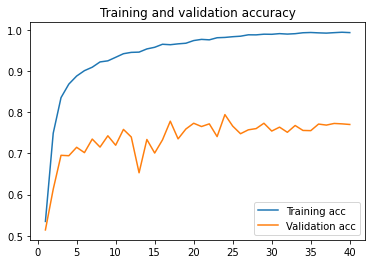

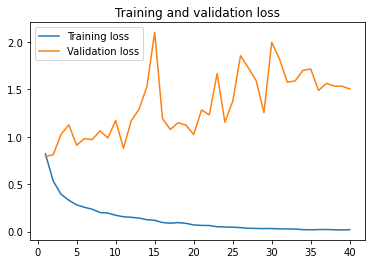

In [39]:
draw_train_graph(history)

In [43]:
model1.evaluate(x_test,y_test)

79/79 [==============================] - 7s 75ms/step - loss: 1.3594 - accuracy: 0.7656


[1.3594245910644531, 0.7655502557754517]

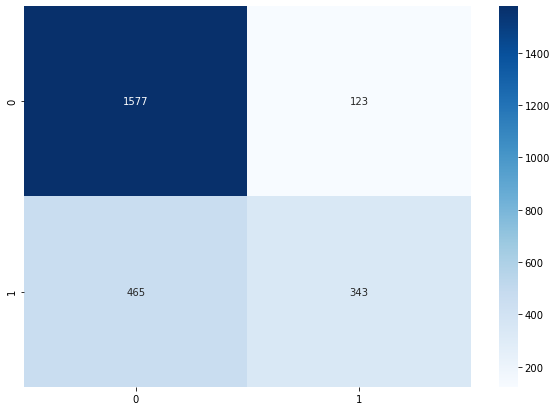

In [41]:
y_test_predict = draw_confusion_matrix(model1,x_test,y_test)

In [42]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.77      0.93      0.84      1700
      normal       0.74      0.42      0.54       808

    accuracy                           0.77      2508
   macro avg       0.75      0.68      0.69      2508
weighted avg       0.76      0.77      0.74      2508



In [47]:
model1.save('inception_V3_model/my_model1_acc77.h5')

<a name="3.2"></a>

### model on oversampled data

In [48]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/original/oversampled/'

In [49]:
train_generator,valid_generator = create_generators(train_path)

Found 10866 images belonging to 2 classes.
Found 2716 images belonging to 2 classes.


In [53]:
model2=build_model()
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_3 (Dropout)         (None, 51200)             0         
                                                                 
 batch_normalization_662 (Ba  (None, 51200)            204800    
 tchNormalization)                                               
                                                                 
 dense_5 (Dense)             (None, 1)                 51201     
                                                                 
Total params: 22,058,785
Trainable params: 21,921,953
Non-trainable params: 136,832
____________________________________

In [54]:
history= train_model(model2 ,train_generator ,valid_generator)

Epoch 1/40
680/680 [==============================] - ETA: 0s - loss: 0.8219 - accuracy: 0.5274INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


680/680 [==============================] - 309s 446ms/step - loss: 0.8219 - accuracy: 0.5274 - val_loss: 0.6963 - val_accuracy: 0.5902 - lr: 1.0000e-08
Epoch 2/40
680/680 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.7679INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


680/680 [==============================] - 312s 458ms/step - loss: 0.5029 - accuracy: 0.7679 - val_loss: 0.3315 - val_accuracy: 0.8490 - lr: 1.0007e-05
Epoch 3/40
680/680 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8302INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


680/680 [==============================] - 295s 433ms/step - loss: 0.3927 - accuracy: 0.8302 - val_loss: 0.2688 - val_accuracy: 0.8914 - lr: 2.0003e-05
Epoch 4/40
680/680 [==============================] - 262s 385ms/step - loss: 0.3434 - accuracy: 0.8533 - val_loss: 0.4114 - val_accuracy: 0.8270 - lr: 3.0000e-05
Epoch 5/40
680/680 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.8725INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


680/680 [==============================] - 194s 285ms/step - loss: 0.3130 - accuracy: 0.8725 - val_loss: 0.1484 - val_accuracy: 0.9426 - lr: 2.9946e-05
Epoch 6/40
680/680 [==============================] - 147s 215ms/step - loss: 0.2838 - accuracy: 0.8881 - val_loss: 0.3573 - val_accuracy: 0.8560 - lr: 2.9784e-05
Epoch 7/40
680/680 [==============================] - 134s 197ms/step - loss: 0.2405 - accuracy: 0.9060 - val_loss: 0.1615 - val_accuracy: 0.9334 - lr: 2.9516e-05
Epoch 8/40
680/680 [==============================] - ETA: 0s - loss: 0.2290 - accuracy: 0.9088INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


680/680 [==============================] - 206s 303ms/step - loss: 0.2290 - accuracy: 0.9088 - val_loss: 0.1219 - val_accuracy: 0.9577 - lr: 2.9143e-05
Epoch 9/40
680/680 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9201INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


680/680 [==============================] - 228s 334ms/step - loss: 0.2062 - accuracy: 0.9201 - val_loss: 0.1013 - val_accuracy: 0.9643 - lr: 2.8668e-05
Epoch 10/40
680/680 [==============================] - 221s 324ms/step - loss: 0.1947 - accuracy: 0.9257 - val_loss: 0.1472 - val_accuracy: 0.9451 - lr: 2.8095e-05
Epoch 11/40
680/680 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9278INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


680/680 [==============================] - 166s 244ms/step - loss: 0.1798 - accuracy: 0.9278 - val_loss: 0.0773 - val_accuracy: 0.9735 - lr: 2.7428e-05
Epoch 12/40
680/680 [==============================] - 139s 204ms/step - loss: 0.1693 - accuracy: 0.9332 - val_loss: 0.0835 - val_accuracy: 0.9665 - lr: 2.6671e-05
Epoch 13/40
680/680 [==============================] - 144s 212ms/step - loss: 0.1490 - accuracy: 0.9434 - val_loss: 0.0876 - val_accuracy: 0.9705 - lr: 2.5829e-05
Epoch 14/40
680/680 [==============================] - 143s 211ms/step - loss: 0.1398 - accuracy: 0.9470 - val_loss: 0.0938 - val_accuracy: 0.9639 - lr: 2.4910e-05
Epoch 15/40
680/680 [==============================] - ETA: 0s - loss: 0.1463 - accuracy: 0.9443INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


680/680 [==============================] - 175s 257ms/step - loss: 0.1463 - accuracy: 0.9443 - val_loss: 0.0771 - val_accuracy: 0.9709 - lr: 2.3919e-05
Epoch 16/40
680/680 [==============================] - 189s 278ms/step - loss: 0.1327 - accuracy: 0.9493 - val_loss: 0.0933 - val_accuracy: 0.9669 - lr: 2.2865e-05
Epoch 17/40
680/680 [==============================] - 150s 220ms/step - loss: 0.1130 - accuracy: 0.9555 - val_loss: 0.1228 - val_accuracy: 0.9543 - lr: 2.1753e-05
Epoch 18/40
680/680 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9566INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inc_V3_model\checkpoint\assets


680/680 [==============================] - 175s 257ms/step - loss: 0.1138 - accuracy: 0.9566 - val_loss: 0.0525 - val_accuracy: 0.9831 - lr: 2.0593e-05
Epoch 19/40
680/680 [==============================] - 158s 232ms/step - loss: 0.1091 - accuracy: 0.9603 - val_loss: 0.1178 - val_accuracy: 0.9588 - lr: 1.9392e-05
Epoch 20/40
680/680 [==============================] - 137s 201ms/step - loss: 0.0978 - accuracy: 0.9622 - val_loss: 0.1108 - val_accuracy: 0.9595 - lr: 1.8160e-05
Epoch 21/40
680/680 [==============================] - 179s 263ms/step - loss: 0.0822 - accuracy: 0.9682 - val_loss: 0.0990 - val_accuracy: 0.9661 - lr: 1.6905e-05
Epoch 22/40
680/680 [==============================] - 161s 237ms/step - loss: 0.0800 - accuracy: 0.9702 - val_loss: 0.0680 - val_accuracy: 0.9746 - lr: 1.5637e-05
Epoch 23/40
680/680 [==============================] - 141s 207ms/step - loss: 0.0709 - accuracy: 0.9752 - val_loss: 0.0802 - val_accuracy: 0.9680 - lr: 1.4363e-05
Epoch 24/40
680/680 [=======

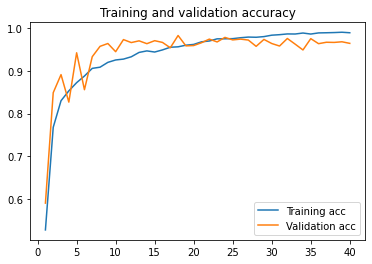

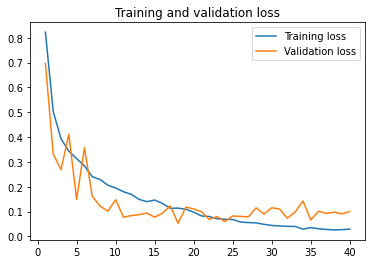

In [55]:
draw_train_graph(history)

In [61]:
model2.evaluate(x_test,y_test)

79/79 [==============================] - 7s 74ms/step - loss: 0.6354 - accuracy: 0.8341


[0.6354139447212219, 0.8341307640075684]

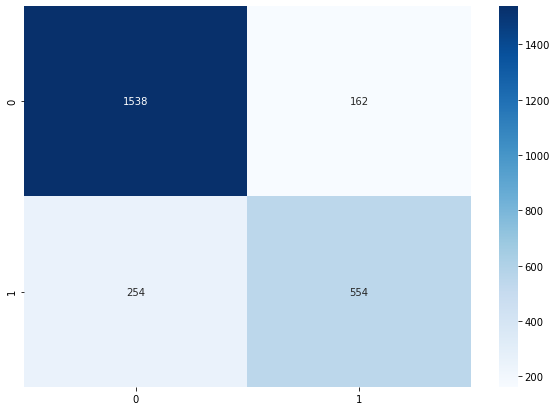

In [57]:
y_test_predict = draw_confusion_matrix(model2,x_test,y_test)

In [58]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.86      0.90      0.88      1700
      normal       0.77      0.69      0.73       808

    accuracy                           0.83      2508
   macro avg       0.82      0.80      0.80      2508
weighted avg       0.83      0.83      0.83      2508



In [62]:
model2.save('inception_V3_model/my_model2_acc83.h5')

<a name="3.3"></a>

### model on undersampled data

In [64]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/original/undersampled/'

In [65]:
train_generator,valid_generator = create_generators(train_path)

Found 5168 images belonging to 2 classes.
Found 1290 images belonging to 2 classes.


<a name="2"></a>

### build the model

In [66]:
model3=build_model()

model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_4 (Dropout)         (None, 51200)             0         
                                                                 
 batch_normalization_757 (Ba  (None, 51200)            204800    
 tchNormalization)                                               
                                                                 
 dense_6 (Dense)             (None, 1)                 51201     
                                                                 
Total params: 22,058,785
Trainable params: 21,921,953
Non-trainable params: 136,832
____________________________________

<a name="2.1"></a>

### model complie & train

In [67]:
history=train_model(model3,train_generator,valid_generator)

Epoch 1/40
323/323 [==============================] - ETA: 0s - loss: 0.8368 - accuracy: 0.5224INFO:tensorflow:Assets written to: ./inception_V3_model\checkpoint\assets


INFO:tensorflow:Assets written to: ./inception_V3_model\checkpoint\assets


323/323 [==============================] - 238s 720ms/step - loss: 0.8368 - accuracy: 0.5224 - val_loss: 0.7507 - val_accuracy: 0.5512 - lr: 1.0000e-08
Epoch 2/40
323/323 [==============================] - 62s 189ms/step - loss: 0.6220 - accuracy: 0.6885 - val_loss: 0.9243 - val_accuracy: 0.6047 - lr: 1.0007e-05
Epoch 3/40
323/323 [==============================] - 66s 205ms/step - loss: 0.5115 - accuracy: 0.7705 - val_loss: 0.9844 - val_accuracy: 0.6163 - lr: 2.0003e-05
Epoch 4/40
323/323 [==============================] - 65s 201ms/step - loss: 0.4399 - accuracy: 0.8069 - val_loss: 1.1850 - val_accuracy: 0.6039 - lr: 3.0000e-05
Epoch 5/40
323/323 [==============================] - 66s 204ms/step - loss: 0.3604 - accuracy: 0.8508 - val_loss: 1.1866 - val_accuracy: 0.6225 - lr: 2.9946e-05
Epoch 6/40
323/323 [==============================] - 64s 198ms/step - loss: 0.3402 - accuracy: 0.8547 - val_loss: 1.2639 - val_accuracy: 0.6395 - lr: 2.9784e-05
Epoch 7/40
323/323 [==================

<a name="2.2"></a>

### train & validation loss and accuracy per epochs

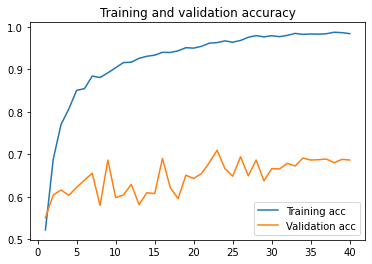

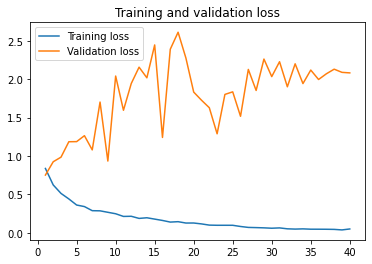

In [68]:
draw_train_graph(history)

In [77]:
model3.evaluate(x_test,y_test)

79/79 [==============================] - 7s 72ms/step - loss: 1.5399 - accuracy: 0.7532


[1.5398921966552734, 0.7531898021697998]

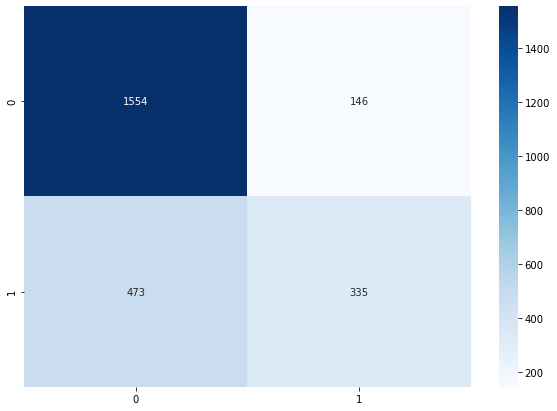

In [70]:
y_test_predict = draw_confusion_matrix(model3,x_test,y_test)

In [71]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.77      0.91      0.83      1700
      normal       0.70      0.41      0.52       808

    accuracy                           0.75      2508
   macro avg       0.73      0.66      0.68      2508
weighted avg       0.74      0.75      0.73      2508



In [73]:
model3.save('inception_V3_model/my_model3_acc75.h5')

<a name="4"></a>
##  <span style="color:blue"> **train the model on the paper preprocessed data** </span>

<a name="4.1"></a>

### the model on preprocessed imbalanced data

In [19]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/paper preprocessed/imbalanced/'

In [20]:
train_generator,valid_generator = create_generators(train_path)

Found 8017 images belonging to 2 classes.
Found 2003 images belonging to 2 classes.


<a name="2"></a>

#### build the model

In [21]:
model4=build_model()

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 batch_normalization_94 (Bat  (None, 51200)            204800    
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 1)                 51201     
                                                                 
Total params: 22,058,785
Trainable params: 21,921,953
Non-trainable params: 136,832
______________________________________

<a name="2.1"></a>

### model complie & train

In [22]:
history=train_model(model4,train_generator,valid_generator)

Epoch 1/40
502/502 [==============================] - 465s 885ms/step - loss: 0.8862 - accuracy: 0.4907 - val_loss: 0.8555 - val_accuracy: 0.4438 - lr: 1.0000e-08
Epoch 2/40
502/502 [==============================] - 122s 243ms/step - loss: 0.5982 - accuracy: 0.7041 - val_loss: 0.6074 - val_accuracy: 0.6960 - lr: 1.0007e-05
Epoch 3/40
502/502 [==============================] - 120s 238ms/step - loss: 0.4924 - accuracy: 0.7822 - val_loss: 0.5853 - val_accuracy: 0.7174 - lr: 2.0003e-05
Epoch 4/40
502/502 [==============================] - 95s 189ms/step - loss: 0.4826 - accuracy: 0.7919 - val_loss: 0.7234 - val_accuracy: 0.6630 - lr: 3.0000e-05
Epoch 5/40
502/502 [==============================] - 123s 245ms/step - loss: 0.4510 - accuracy: 0.8175 - val_loss: 0.5599 - val_accuracy: 0.7444 - lr: 2.9946e-05
Epoch 6/40
502/502 [==============================] - 122s 242ms/step - loss: 0.4204 - accuracy: 0.8219 - val_loss: 0.5391 - val_accuracy: 0.7644 - lr: 2.9784e-05
Epoch 7/40
502/502 [===

502/502 [==============================] - 96s 191ms/step - loss: 0.1396 - accuracy: 0.9436 - val_loss: 0.4144 - val_accuracy: 0.8427 - lr: 4.8401e-07
Epoch 39/40
502/502 [==============================] - 96s 191ms/step - loss: 0.1372 - accuracy: 0.9440 - val_loss: 0.4128 - val_accuracy: 0.8447 - lr: 2.1576e-07
Epoch 40/40
502/502 [==============================] - 100s 199ms/step - loss: 0.1478 - accuracy: 0.9430 - val_loss: 0.4187 - val_accuracy: 0.8417 - lr: 5.4038e-08


<a name="2.2"></a>

### train & validation loss and accuracy per epochs

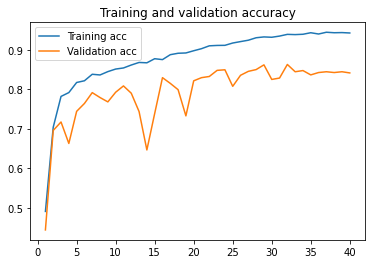

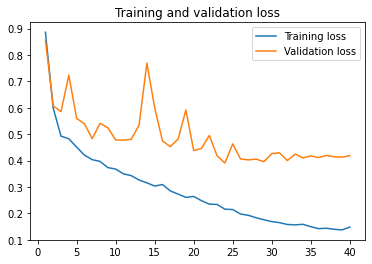

In [23]:
draw_train_graph(history)

In [8]:
model4.evaluate(x_test,y_test)

79/79 [==============================] - 39s 302ms/step - loss: 0.7156 - accuracy: 0.7081


[0.7156015038490295, 0.7081339955329895]

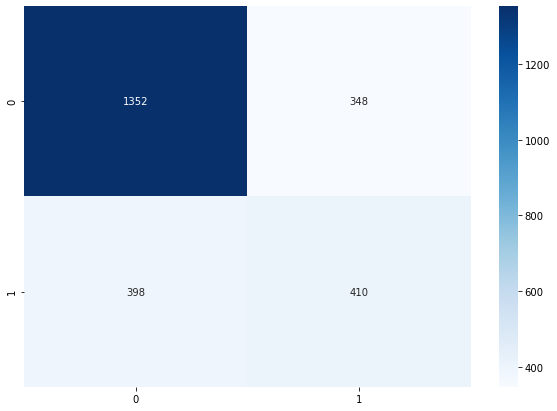

In [24]:
y_test_predict = draw_confusion_matrix(model4,x_test,y_test)

In [25]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.77      0.80      0.78      1700
      normal       0.54      0.51      0.52       808

    accuracy                           0.70      2508
   macro avg       0.66      0.65      0.65      2508
weighted avg       0.70      0.70      0.70      2508



In [26]:
model4.save('inception_V3_model/my_model4_acc70.h5')

<a name="4.2"></a>

### the model on preprocessed oversampled data

In [30]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/paper preprocessed/oversampled/'

In [31]:
train_generator,valid_generator = create_generators(train_path)

Found 10866 images belonging to 2 classes.
Found 2716 images belonging to 2 classes.


<a name="2"></a>

### build the model

In [32]:
model5=build_model()

model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_1 (Dropout)         (None, 51200)             0         
                                                                 
 batch_normalization_189 (Ba  (None, 51200)            204800    
 tchNormalization)                                               
                                                                 
 dense_1 (Dense)             (None, 1)                 51201     
                                                                 
Total params: 22,058,785
Trainable params: 21,921,953
Non-trainable params: 136,832
____________________________________

<a name="2.1"></a>

### model complie & train

In [33]:
history=train_model(model5,train_generator,valid_generator)

Epoch 1/40
680/680 [==============================] - 660s 962ms/step - loss: 0.8481 - accuracy: 0.5051 - val_loss: 0.8154 - val_accuracy: 0.5074 - lr: 1.0000e-08
Epoch 2/40
680/680 [==============================] - 519s 764ms/step - loss: 0.5148 - accuracy: 0.7556 - val_loss: 0.5100 - val_accuracy: 0.7452 - lr: 1.0007e-05
Epoch 3/40
680/680 [==============================] - 147s 215ms/step - loss: 0.4285 - accuracy: 0.8161 - val_loss: 0.4946 - val_accuracy: 0.7515 - lr: 2.0003e-05
Epoch 4/40
680/680 [==============================] - 158s 232ms/step - loss: 0.4148 - accuracy: 0.8228 - val_loss: 0.2858 - val_accuracy: 0.8855 - lr: 3.0000e-05
Epoch 5/40
680/680 [==============================] - 137s 201ms/step - loss: 0.3850 - accuracy: 0.8378 - val_loss: 0.3722 - val_accuracy: 0.8343 - lr: 2.9946e-05
Epoch 6/40
680/680 [==============================] - 157s 230ms/step - loss: 0.3610 - accuracy: 0.8474 - val_loss: 0.2512 - val_accuracy: 0.8943 - lr: 2.9784e-05
Epoch 7/40
680/680 [==

<a name="2.2"></a>

### train & validation loss and accuracy per epochs

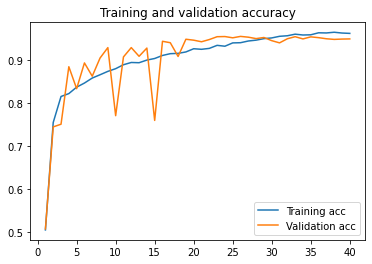

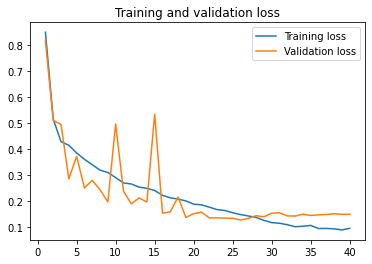

In [34]:
draw_train_graph(history)

In [38]:
model5.evaluate(x_test,y_test)

79/79 [==============================] - 8s 76ms/step - loss: 0.9507 - accuracy: 0.7313


[0.950700044631958, 0.7312599420547485]

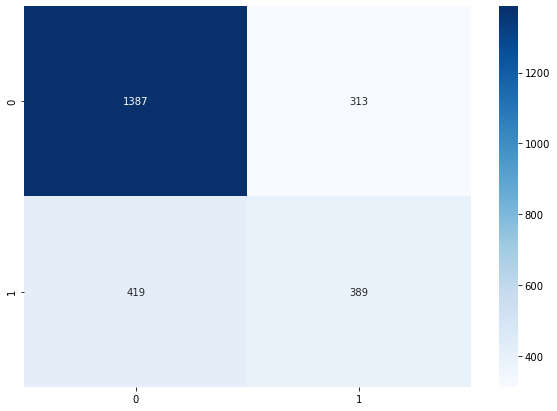

In [35]:
y_test_predict = draw_confusion_matrix(model6,x_test,y_test)

In [36]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.77      0.82      0.79      1700
      normal       0.55      0.48      0.52       808

    accuracy                           0.71      2508
   macro avg       0.66      0.65      0.65      2508
weighted avg       0.70      0.71      0.70      2508



In [39]:
model5.save('inception_V3_model/my_model5_acc71.h5')

<a name="4.3"></a>

### the model on undersampled preprocessed data

In [17]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/paper preprocessed/undersampled/'

In [18]:
train_generator ,valid_generator = create_generators(train_path)

Found 5168 images belonging to 2 classes.
Found 1290 images belonging to 2 classes.


In [19]:
model6=build_model()
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 batch_normalization_94 (Bat  (None, 51200)            204800    
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 1)                 51201     
                                                                 
Total params: 22,058,785
Trainable params: 21,921,953
Non-trainable params: 136,832
______________________________________

In [20]:
history= train_model(model6 ,train_generator ,valid_generator)

Epoch 1/40
323/323 [==============================] - 241s 722ms/step - loss: 0.8469 - accuracy: 0.5174 - val_loss: 0.7911 - val_accuracy: 0.4760 - lr: 1.0000e-08
Epoch 2/40
323/323 [==============================] - 108s 331ms/step - loss: 0.6862 - accuracy: 0.6577 - val_loss: 0.5193 - val_accuracy: 0.7581 - lr: 1.0007e-05
Epoch 3/40
323/323 [==============================] - 78s 241ms/step - loss: 0.6004 - accuracy: 0.7140 - val_loss: 0.5060 - val_accuracy: 0.7372 - lr: 2.0003e-05
Epoch 4/40
323/323 [==============================] - 79s 244ms/step - loss: 0.5721 - accuracy: 0.7345 - val_loss: 0.4990 - val_accuracy: 0.7674 - lr: 3.0000e-05
Epoch 5/40
323/323 [==============================] - 52s 161ms/step - loss: 0.5435 - accuracy: 0.7523 - val_loss: 0.5222 - val_accuracy: 0.7605 - lr: 2.9946e-05
Epoch 6/40
323/323 [==============================] - 79s 246ms/step - loss: 0.5283 - accuracy: 0.7628 - val_loss: 0.4432 - val_accuracy: 0.8008 - lr: 2.9784e-05
Epoch 7/40
323/323 [======

Epoch 38/40
323/323 [==============================] - 196s 606ms/step - loss: 0.2400 - accuracy: 0.8996 - val_loss: 0.3466 - val_accuracy: 0.8527 - lr: 4.8401e-07
Epoch 39/40
323/323 [==============================] - 124s 383ms/step - loss: 0.2343 - accuracy: 0.9036 - val_loss: 0.3485 - val_accuracy: 0.8566 - lr: 2.1576e-07
Epoch 40/40
323/323 [==============================] - 53s 163ms/step - loss: 0.2210 - accuracy: 0.9106 - val_loss: 0.3510 - val_accuracy: 0.8512 - lr: 5.4038e-08


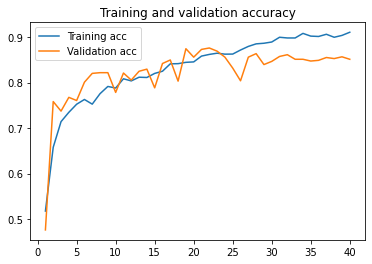

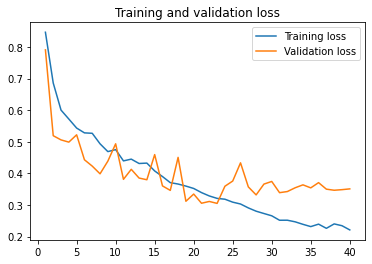

In [22]:
draw_train_graph(history)

In [27]:
model6.evaluate(x_test,y_test)

79/79 [==============================] - 7s 72ms/step - loss: 0.7156 - accuracy: 0.7081


[0.7156036496162415, 0.7081339955329895]

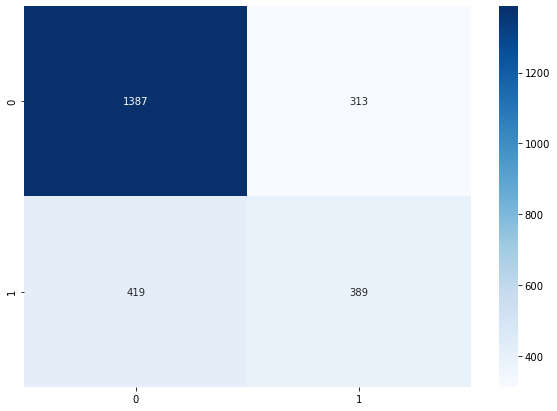

In [23]:
y_test_predict = draw_confusion_matrix(model6,x_test,y_test)

In [24]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.77      0.82      0.79      1700
      normal       0.55      0.48      0.52       808

    accuracy                           0.71      2508
   macro avg       0.66      0.65      0.65      2508
weighted avg       0.70      0.71      0.70      2508



In [29]:
model6.save('inception_V3_model/my_model6_acc71.h5')

In [19]:
image=np.expand_dims(x_test[1],axis=0)

np.round(model5.predict(image))

array([[0.]], dtype=float32)

In [18]:
y_test[1]

0